In [23]:
import numpy as np
import random
from collections import defaultdict
import datetime as dt
import os
import pickle as pkl
import torch
from torch.utils.data import Dataset, DataLoader
import yaml
import zarr
import label_utils
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

ModuleNotFoundError: No module named 'seaborn'

In [2]:
ROOT_DIR = "timematch_data"
SOURCE_DIR = "denmark/32VNH/2017"
TARGET_DIR = "timematch_data/denmark/32VNH/2017"
OUTPUT_DIR = "/content/outputs"
NUM_FOLDS = 5
VAL_RATIO = 0.2
TEST_RATIO = 0.1

In [3]:
def read_yaml_class_mapping(country):
    return yaml.load(open("denmark_class_mapping.yml"), Loader=yaml.FullLoader)

def get_code_to_class(country, combine_spring_and_winter=False):
    class_mapping = read_yaml_class_mapping(country)

    code_to_class = {}
    for cls in class_mapping.keys():
        codes = class_mapping[cls]
        if codes is None:
            continue
        if 'spring' in codes and 'winter' in codes:
            if combine_spring_and_winter:
                combined = {**(codes['spring'] if codes['spring'] is not None else {}), **(codes['winter'] if codes['winter'] is not None else {})}
                code_to_class.update({code: cls for code in combined})
            else:
                if codes['spring'] is not None:
                    code_to_class.update({code: f'spring_{cls}' for code in codes['spring'].keys()})
                if codes['winter'] is not None:
                    code_to_class.update({code: f'winter_{cls}' for code in codes['winter'].keys()})
        else:
            code_to_class.update({code: cls for code in codes})
    return code_to_class

def get_classes(*countries, method=set.union, combine_spring_and_winter=False):
    class_sets = []
    for country in countries:
        code_to_class = get_code_to_class(country, combine_spring_and_winter)
        class_sets.append(set(code_to_class.values()))

    classes = sorted(list(method(*class_sets)))
    return classes

In [4]:
class PixelSetData(Dataset):
    def __init__(
        self,
        data_root,
        dataset_name,
        classes,
        transform=None,
        indices=None,
        with_extra=False,
    ):
        super(PixelSetData, self).__init__()

        self.folder = os.path.join(data_root, dataset_name)
        self.dataset_name = dataset_name  # country/tile/year
        self.country = dataset_name.split("/")[-3]
        self.tile = dataset_name.split("/")[-2]
        self.data_folder = os.path.join(self.folder, "data")
        self.meta_folder = os.path.join(self.folder, "meta")
        self.transform = transform
        self.with_extra = with_extra

        self.classes = classes
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

        self.samples, self.metadata = self.make_dataset(
            self.data_folder, self.meta_folder, self.class_to_idx, indices, self.country
        )

        self.dates = self.metadata["dates"]
        self.date_positions = self.days_after(self.metadata["start_date"], self.dates)
        self.date_indices = np.arange(len(self.date_positions))

    def get_shapes(self):
        return [
            (len(self.dates), 10, parcel["n_pixels"])
            for parcel in self.metadata["parcels"]
        ]

    def get_labels(self):
        return np.array([x[2] for x in self.samples])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, parcel_idx, y, extra = self.samples[index]
        pixels = zarr.load(path)  # (T, C, S)

        sample = {
            "index": index,
            "parcel_index": parcel_idx,  # mapping to metadata
            "pixels": pixels,
            "valid_pixels": np.ones(
                (pixels.shape[0], pixels.shape[-1]), dtype=np.float32),
            "positions": np.array(self.date_positions),
            "extra": np.array(extra),
            "label": y,
        }

        if self.transform is not None:
            sample = self.transform(sample)

        return sample

    def make_dataset(self, data_folder, meta_folder, class_to_idx, indices, country):
        metadata = pkl.load(open(os.path.join(meta_folder, "metadata.pkl"), "rb"))

        instances = []
        new_parcel_metadata = []

        code_to_class_name = get_code_to_class(country)

        unknown_crop_codes = set()

        for parcel_idx, parcel in enumerate(metadata["parcels"]):
            if indices is not None:
                if not parcel_idx in indices:
                    continue
            crop_code = parcel["label"]
            if country == "austria":
                crop_code = int(crop_code)
            parcel_path = os.path.join(data_folder, f"{parcel_idx}.zarr")
            if not os.path.exists(parcel_path):
                continue 
            if crop_code not in code_to_class_name:
                unknown_crop_codes.add(crop_code)
            class_name = code_to_class_name.get(crop_code, "unknown")
            class_index = class_to_idx.get(class_name, class_to_idx["unknown"])
            extra = parcel['geometric_features']

            item = (parcel_path, parcel_idx, class_index, extra)
            instances.append(item)
            new_parcel_metadata.append(parcel)

        for crop_code in unknown_crop_codes:
            print(
                f"Parcels with crop code {crop_code} was not found in .yml class mapping and was assigned to unknown."
            )

        metadata["parcels"] = new_parcel_metadata

        assert len(metadata["parcels"]) == len(instances)

        return instances, metadata

    def days_after(self, start_date, dates):
        def parse(date):
            d = str(date)
            return int(d[:4]), int(d[4:6]), int(d[6:])

        def interval_days(date1, date2):
            return abs((dt.datetime(*parse(date1)) - dt.datetime(*parse(date2))).days)

        date_positions = [interval_days(d, start_date) for d in dates]
        return date_positions

    def get_unknown_labels(self):
        """
        Reports the categorization of crop codes for this dataset
        """
        class_count = defaultdict(int)
        class_parcel_size = defaultdict(float)
        # metadata = pkl.load(open(os.path.join(self.meta_folder, 'metadata.pkl'), 'rb'))
        metadata = self.metadata
        for meta in metadata["parcels"]:
            class_count[meta["label"]] += 1
            class_parcel_size[meta["label"]] += meta["n_pixels"]

        class_avg_parcel_size = {
            cls: total_px / class_count[cls]
            for cls, total_px in class_parcel_size.items()
        }

        code_to_class_name = label_utils.get_code_to_class(self.country)
        codification_table = label_utils.get_codification_table(self.country)
        unknown = []
        known = defaultdict(list)
        for code, count in class_count.items():
            avg_pixels = class_avg_parcel_size[code]
            if self.country == "denmark":
                code = int(code)
            code_name = codification_table[str(code)]
            if code in code_to_class_name:
                known[code_to_class_name[code]].append(
                    (code, code_name, count, avg_pixels)
                )
            else:
                unknown.append((code, code_name, count, avg_pixels))

        print("\nCategorized crop codes:")
        for class_name, codes in known.items():
            total_parcels = sum(x[2] for x in codes)
            avg_parcel_size = sum(x[3] for x in codes) / len(codes)
            print(f"{class_name} (n={total_parcels}, avg size={avg_parcel_size:.3f}):")
            codes = reversed(sorted(codes, key=lambda x: x[2]))
            for code, code_name, count, avg_pixels in codes:
                print(f"  {code}: {code_name} (n={count}, avg pixels={avg_pixels:.1f})")
        unknown = reversed(sorted(unknown, key=lambda x: x[2]))
        print("\nUncategorized crop codes:")
        for code, code_name, count, avg_pixels in unknown:
            print(f"  {code}: {code_name} (n={count}, avg pixels={avg_pixels:.1f})")

In [5]:
len(os.listdir("timematch_data/denmark/32VNH/2017/data"))

4996

In [6]:
classes = get_classes("denmark")
dataset = PixelSetData(ROOT_DIR, SOURCE_DIR, classes, with_extra=False)
print(dataset[0])
print(dataset[0].keys())

{'index': 0, 'parcel_index': 0, 'pixels': array([[[1749, 1726, 1807, ..., 1839, 1856, 1889],
        [1214, 1188, 1201, ..., 1283, 1300, 1318],
        [1185, 1160, 1169, ..., 1333, 1290, 1315],
        ...,
        [2196, 2141, 2056, ..., 1962, 2046, 1954],
        [1396, 1394, 1276, ..., 1022, 1050,  970],
        [ 859,  855,  816, ...,  682,  708,  658]],

       [[1193, 1178, 1198, ..., 3014, 3054, 3096],
        [ 812,  810,  803, ..., 2564, 2554, 2646],
        [ 659,  676,  681, ..., 2638, 2714, 2820],
        ...,
        [1013,  994, 1039, ..., 3245, 3232, 3312],
        [ 887,  893,  905, ..., 2628, 2650, 2726],
        [ 528,  534,  550, ..., 2021, 2034, 2096]],

       [[   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        ...,
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0],
        [   0,    0,    0, ...,    0,    0,    0

In [7]:
len(os.listdir("timematch_data/denmark/32VNH/2017/data"))

4996

In [8]:
len(dataset)

4996

In [9]:
import zarr

valid_idxs = []
for i in range(len(dataset)):
    path, _, _, _ = dataset.samples[i]
    try:
        _ = zarr.load(path)
        valid_idxs.append(i)
    except NotImplementedError:
        print(f"Index {i} → Path {path} is a Zarr group (not loadable)")
        
print(f"{len(valid_idxs)} / {len(dataset)} are valid data points")

4996 / 4996 are valid data points


In [14]:
class WrappedPixelSubset(Dataset):
    def __init__(self, base_dataset, indices, sample_pixels=None, is_validation=False):
        self.base_dataset = base_dataset
        self.indices = list(indices)
        self.sample_pixels = sample_pixels
        self.is_validation = is_validation

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        sample = self.base_dataset[self.indices[idx]]

        # Apply pixel sampling only if training
        if not self.is_validation and self.sample_pixels is not None:
            pixels = sample["pixels"]  # (T, C, S)
            total_pixels = pixels.shape[-1]

            if total_pixels >= self.sample_pixels:
                sampled_indices = np.random.choice(total_pixels, self.sample_pixels, replace=False)
            else:
                sampled_indices = np.random.choice(total_pixels, self.sample_pixels, replace=True)

            pixels = pixels[:, :, sampled_indices]
            sample["pixels"] = pixels
            sample["valid_pixels"] = np.ones((pixels.shape[0], pixels.shape[-1]), dtype=np.float32)

        return sample

In [15]:
def get_dataloaders_for_cv(dataset, n_splits=5, sample_pixels=32, batch_size=8):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    indices = list(range(len(dataset)))
    dataloaders = []

    for train_idx, val_idx in kf.split(indices):
        train_subset = WrappedPixelSubset(dataset, train_idx, sample_pixels=sample_pixels, is_validation=False)
        val_subset = WrappedPixelSubset(dataset, val_idx, sample_pixels=None, is_validation=True)
        #print(train_subset[0])
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
        print(next(iter(train_loader)))
        dataloaders.append((train_loader, val_loader))

    return dataloaders


In [16]:
cv_loaders = get_dataloaders_for_cv(dataset, n_splits=5, sample_pixels=32, batch_size=8)

{'index': tensor([3456, 1571, 2041,  183, 2940,   36, 1971, 3530]), 'parcel_index': tensor([3458, 1573, 2043,  183, 2942,   36, 1973, 3533]), 'pixels': tensor([[[[1577, 1563, 1535,  ..., 1517, 1550, 1572],
          [1091, 1070, 1083,  ..., 1071, 1063, 1088],
          [ 970,  990,  939,  ...,  981,  964,  962],
          ...,
          [1968, 1972, 1845,  ..., 2019, 2020, 1734],
          [ 899,  825,  790,  ...,  908,  902,  884],
          [ 552,  520,  485,  ...,  561,  560,  578]],

         [[2645, 2506, 2702,  ..., 3035, 2339, 3114],
          [2115, 2117, 2285,  ..., 2413, 2108, 2661],
          [2033, 1967, 2479,  ..., 2648, 2342, 2781],
          ...,
          [2690, 2619, 2894,  ..., 3174, 2834, 3295],
          [2023, 1965, 2320,  ..., 2521, 2191, 2848],
          [1366, 1325, 1582,  ..., 1732, 1548, 2026]],

         [[4655, 4572, 3201,  ..., 4737, 3849, 3671],
          [4073, 4174, 2635,  ..., 4333, 3395, 3293],
          [4579, 4467, 2717,  ..., 4792, 3591, 3592],
    

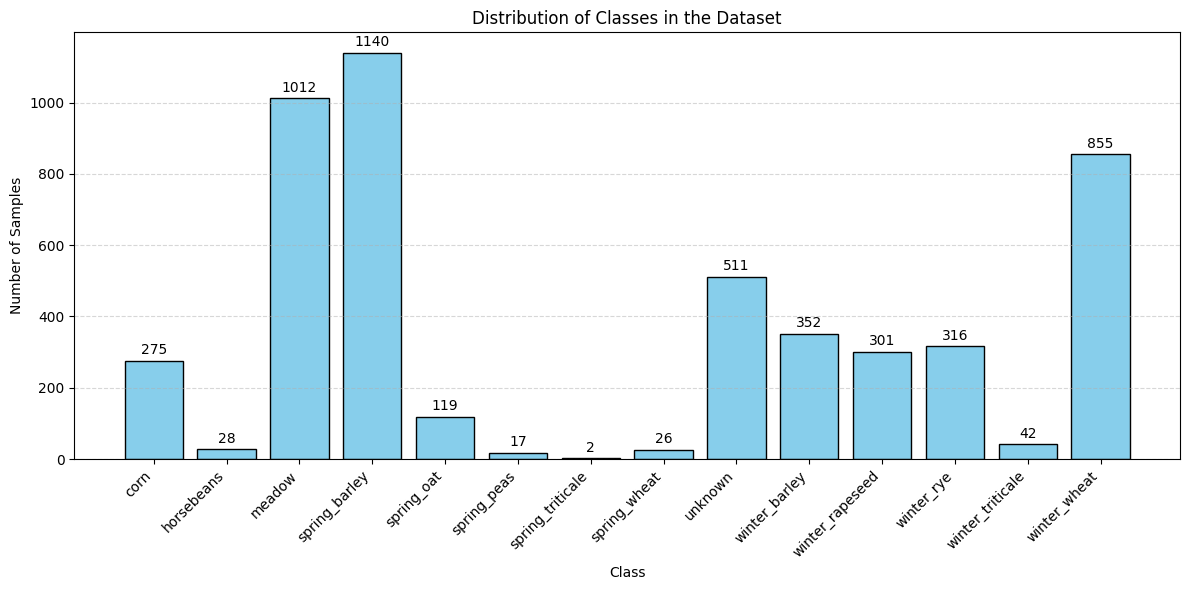

In [24]:
labels, counts = np.unique(dataset.get_labels(), return_counts=True)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
label_names = [idx_to_class[lbl] for lbl in labels]
plt.figure(figsize=(12, 6))
bars = plt.bar(label_names, counts, color='skyblue', edgecolor='black')

# Add counts on top of bars
for bar, count in zip(bars, counts):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 10, str(count),
             ha='center', va='bottom', fontsize=10)

plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Distribution of Classes in the Dataset")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [21]:
dataset.get_unknown_labels()

FileNotFoundError: [Errno 2] No such file or directory: 'class_mapping/denmark_codification_table.csv'